In [2]:
import pandas as pd
import ca_util as ca
import datetime as dt
import sys
import csv
import pickle
import tensorflow as tf
import inspect_checkpoint
from sklearn import preprocessing


config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session=tf.Session(config=config)


In [3]:

# 데이터 전처리 환경 저장한 파일을 불러 옵니다.
with open('./output/preprocess_object.pickle', 'rb') as f:
	preprocess_object = pickle.load(f)

# 훈련데이터 로드 합니다.
dataset = pd.read_csv('./output/test_dataset.csv', delimiter=',' ,encoding='utf-8', low_memory=False)



In [4]:

# 연속형 항목 전처리(표준화) 정보 불러와 적용합니다. 
number_df = dataset.select_dtypes(include=['int64', 'float64'])
scaler = preprocess_object.pop('scaler',None)

# 표준화 적용 & DataFrade/Column 명 적용합니다.
scaler_arr = scaler.transform(number_df)
org_data = pd.DataFrame(scaler_arr, columns=number_df.columns)

# 이산형 데이터 OneHot Encoder 처리 합니다.
categorical = list(dataset.select_dtypes(include=['object']).columns)
oh_encoder = {}

for cat in categorical:
	# OneHot 정보 불러옵니다.
	oh_encoder = preprocess_object[cat]
	# LabelEncoder & OneHot Encoder 불러 옵니다.
	le = oh_encoder['LabelEncoder']
	ohe = oh_encoder['OneHotEncoder']
	# 범주형 LabelEncoder 처리 합니다.
	cat_le_arr = le.transform(dataset[cat])
	cat_ohe_arr = ohe.transform(cat_le_arr.reshape(-1,1)).toarray()
	oh_df = pd.DataFrame(cat_ohe_arr, columns=[cat+'_'+le.inverse_transform([int(i)])[0] for i in range(cat_ohe_arr.shape[1])])
	# OneHot 결과 데이터 추가 합니다.
	org_data = pd.concat([org_data, oh_df], axis=1)

# 반응결과(종속변수) 새로운 데이터셋 분리 합니다.
test_label = pd.DataFrame()
test_label['resp_N'] = org_data['resp_N']
test_label['resp_Y'] = org_data['resp_Y']




In [5]:
print(org_data.head(5))

    PSTN회선수    모바일회선수   SOIP회선수    인터넷회선수   IPTV회선수   와이브로회선수  모바일약정전여개월수  \
0  0.162066  0.423375  1.190592 -1.793871 -0.861728 -0.031609    0.482797   
1  0.162066 -0.859920 -0.447411 -1.793871 -0.861728 -0.031609    0.482797   
2  0.162066  1.706670 -0.447411 -1.793871 -0.861728 -0.031609   -0.375163   
3  0.162066  0.423375 -0.447411 -1.793871 -0.861728 -0.031609   -1.614439   
4  1.926060 -0.859920 -0.447411  1.051825 -0.861728 -0.031609    0.482797   

   모바일해지후개월수        나이  인터넷가입경과개월수  ...  사용유형_주택용  납무방법_QOOK집전화합산  납무방법__  \
0  -0.430781  2.806576   -1.386508  ...       1.0             0.0     0.0   
1   0.320257  0.986672   -1.386508  ...       1.0             0.0     0.0   
2  -0.430781 -0.378255   -1.386508  ...       1.0             0.0     0.0   
3  -0.430781 -1.093217   -1.386508  ...       1.0             0.0     0.0   
4  -0.430781 -0.573245   -1.386508  ...       1.0             0.0     0.0   

   납무방법_개인(신용카드)  납무방법_신용카드  납무방법_은행계좌 자동이체  납무방법_지로  납무방법_지로자동이체  resp_N 

In [6]:
print(org_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6412 entries, 0 to 6411
Columns: 618 entries, PSTN회선수 to resp_Y
dtypes: float64(618)
memory usage: 30.2 MB
None


In [7]:
print(org_data.describe())

           PSTN회선수       모바일회선수      SOIP회선수       인터넷회선수      IPTV회선수  \
count  6412.000000  6412.000000  6412.000000  6412.000000  6412.000000   
mean     -0.010151     0.000680     0.013437     0.013092     0.003418   
std       0.994910     1.037748     1.077168     1.034303     1.023620   
min      -0.719931    -0.859920    -0.447411    -1.793871    -0.861728   
25%      -0.719931    -0.859920    -0.447411    -0.371023    -0.168140   
50%       0.162066     0.423375    -0.447411    -0.371023    -0.168140   
75%       0.162066     0.423375    -0.447411    -0.371023     0.525448   
max       9.864033    26.089276    29.036635    13.857456    32.430493   

           와이브로회선수   모바일약정전여개월수    모바일해지후개월수           나이   인터넷가입경과개월수  ...  \
count  6412.000000  6412.000000  6412.000000  6412.000000  6412.000000  ...   
mean      0.002963     0.009586     0.004969    -0.010080    -0.022019  ...   
std       1.045858     0.998835     1.008506     1.001341     1.000103  ...   
min      -0.03160

In [14]:
org_data.corr().to_csv('./output/org_data_corr.csv', mode='w', encoding='utf-8', header=1, index=0)

In [8]:
print(org_data[['PSTN회선수','resp_N','resp_Y']])

       PSTN회선수  resp_N  resp_Y
0     0.162066     0.0     1.0
1     0.162066     0.0     1.0
2     0.162066     0.0     1.0
3     0.162066     0.0     1.0
4     1.926060     0.0     1.0
5     0.162066     1.0     0.0
6     0.162066     0.0     1.0
7    -0.719931     0.0     1.0
8     1.044063     0.0     1.0
9     0.162066     0.0     1.0
10    0.162066     0.0     1.0
11   -0.719931     1.0     0.0
12   -0.719931     0.0     1.0
13   -0.719931     0.0     1.0
14   -0.719931     0.0     1.0
15   -0.719931     0.0     1.0
16   -0.719931     0.0     1.0
17   -0.719931     0.0     1.0
18   -0.719931     0.0     1.0
19   -0.719931     0.0     1.0
20   -0.719931     0.0     1.0
21    0.162066     0.0     1.0
22    1.044063     0.0     1.0
23   -0.719931     1.0     0.0
24   -0.719931     1.0     0.0
25   -0.719931     0.0     1.0
26   -0.719931     0.0     1.0
27   -0.719931     0.0     1.0
28   -0.719931     1.0     0.0
29   -0.719931     0.0     1.0
...        ...     ...     ...
6382 -0.

In [9]:
#데이터 가공하기
print(org_data[['PSTN회선수','resp_N']].groupby(['PSTN회선수'],as_index=False).mean().sort_values(by='PSTN회선수', ascending=False))

     PSTN회선수    resp_N
11  9.864033  1.000000
10  8.982036  0.000000
9   7.218042  0.200000
8   6.336045  0.000000
7   5.454048  0.000000
6   4.572051  0.105263
5   3.690054  0.315789
4   2.808057  0.260504
3   1.926060  0.227092
2   1.044063  0.312500
1   0.162066  0.265478
0  -0.719931  0.321015


In [10]:
#matplotlib을 이용해 그래프로 표현
import matplotlib.pyplot as plt
import seaborn as sns
#그래프의 크기 결정
plt.figure(figsize=(15 ,15 ))

<Figure size 1500x1500 with 0 Axes>

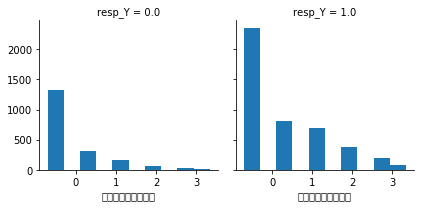

In [15]:
#상관도가 높은 plasma와 class만 떼어 그래프로 확인
grid = sns.FacetGrid(org_data,col='resp_Y')
grid.map(plt.hist,'이동전화결합회선수', bins=10)
plt.show()

In [ ]:
# 데이터셋(독립변수) 반응결과 삭제 합니다.
del org_data['resp_N']
del org_data['resp_Y']

In [ ]:

# index 재정렬 후 삭제 합니다.(drop 하지 않아 현재는 필요 없습니다.)
# org_data = org_data.reset_index()
# del org_data['index']

# DNN 모델 설정 합니다.
X = tf.placeholder(tf.float32, [None, org_data.shape[1]])
Y = tf.placeholder(tf.float32, [None, test_label.shape[1]])
keep_prob = tf.placeholder(tf.float32)

W1 = tf.Variable(tf.random_normal([org_data.shape[1], 256], stddev=0.01))
L1 = tf.nn.sigmoid(tf.matmul(X, W1))

# 텐서플로우에 내장된 함수를 이용하여 dropout 을 적용합니다.
L1 = tf.nn.dropout(L1, keep_prob)

W2 = tf.Variable(tf.random_normal([256, 256], stddev=0.01))
L2 = tf.nn.sigmoid(tf.matmul(L1, W2))
L2 = tf.nn.dropout(L2, keep_prob)

W3 = tf.Variable(tf.random_normal([256, test_label.shape[1]], stddev=0.01))
model = tf.nn.softmax(tf.matmul(L2, W3))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

# 학습한 모델을 불러 옵니다.
init = tf.global_variables_initializer()

save_file = './output/train_model.ckpt'


In [ ]:


with tf.Session(config=config) as sess:
    saver = tf.train.Saver(tf.global_variables())
    print('모델 불러 옵니다.')
    saver.restore(sess, save_file)
    pred = tf.argmax(model, 1)
    
    is_correct = tf.equal(pred, tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
    prediction = sess.run(pred, feed_dict={X: org_data, Y: test_label, keep_prob: 1})
    print('정확도 :', sess.run(accuracy, feed_dict={X: org_data, Y: test_label, keep_prob: 1}))

# 학습  종료 합니다.